In [0]:
#===从GCS加载数据
import warnings
warnings.filterwarnings("ignore")

project_id = 'amazing-firefly-153908'
bucket_name = 'nlp_final'

# 获取授权
from google.colab import auth
auth.authenticate_user()

#从GCS下载数据至tmp
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')
from apiclient.http import MediaIoBaseDownload

In [0]:
def download_from_GCS(file_name):
  with open(file_name, 'wb') as f:
    request = gcs_service.objects().get_media(bucket=bucket_name,
                                              object=file_name)
    media = MediaIoBaseDownload(f, request)

    done = False
    while not done:
      # _ is a placeholder for a progress object that we ignore.
      # (Our file is small, so we skip reporting progress.)
      _, done = media.next_chunk()
  print(file_name + ' downloaded')

In [3]:
download_from_GCS('x_train_all.csv')
download_from_GCS('x_test_all.csv')

x_train_all.csv downloaded
x_test_all.csv downloaded


In [0]:
import numpy as np
import pandas as pd
import time
from tqdm.auto import tqdm
tqdm.pandas()

In [0]:
def get_time():
  seconds = time.time()
  named_tuple = time.gmtime(seconds) # get struct_time
  hour = named_tuple.tm_hour + 8
  if hour > 24:
    hour = hour - 24
  time_str = str(hour) + ':' + str(named_tuple.tm_min) + ':' + str(named_tuple.tm_sec)
  return time_str

In [0]:
from googleapiclient.http import MediaFileUpload
def upload_to_GCS(file_name):
  media = MediaFileUpload(file_name, 
                          mimetype='text/csv',
                          resumable=True)

  request = gcs_service.objects().insert(bucket=bucket_name, 
                                         name=file_name,
                                         media_body=media)

  response = None
  while response is None:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, response = request.next_chunk()
  print(file_name + ' uploaded')

In [0]:
train = pd.read_csv('x_train_all.csv')
test = pd.read_csv('x_test_all.csv')
train = train.iloc[:,1:train.shape[1]]
test = test.iloc[:,1:test.shape[1]]

In [8]:
train.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz
0,2,0.153846,7,0.144330,11.0,0.916667,0.846154,0.361951,0.042975,0.978513,2,0.153846,7,0.147368,11.0,0.916667,0.846154,0.399752,0.050317,0.974841,2,0.153846,7,0.147368,11.0,0.916667,0.846154,0.399752,0.050317,0.974841
1,5,0.400000,32,0.581818,7.0,0.560000,0.388889,2.381508,0.499939,0.750030,5,0.400000,28,0.528302,7.0,0.560000,0.388889,2.352287,0.486068,0.756966,5,0.400000,28,0.528302,7.0,0.560000,0.388889,2.352180,0.486033,0.756984
2,4,0.333333,10,0.185185,4.0,0.320000,0.190476,4.300143,1.490253,0.254874,4,0.333333,10,0.208333,5.0,0.400000,0.250000,3.537197,1.215205,0.392397,4,0.333333,10,0.212766,5.0,0.400000,0.250000,3.537193,1.215203,0.392398
3,2,0.166667,9,0.211765,0.0,0.000000,0.000000,5.397345,2.000000,0.000000,2,0.166667,10,0.263158,0.0,0.000000,0.000000,5.417527,2.000000,0.000000,2,0.166667,10,0.263158,0.0,0.000000,0.000000,5.428626,2.000000,0.000000
4,6,0.600000,30,0.638298,4.0,0.380952,0.235294,4.336044,1.443889,0.278056,6,0.600000,28,0.622222,4.0,0.380952,0.235294,4.321019,1.428437,0.285782,6,0.600000,28,0.622222,4.0,0.380952,0.235294,4.321019,1.428437,0.285782


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73760131d0>,
      dtype=object)

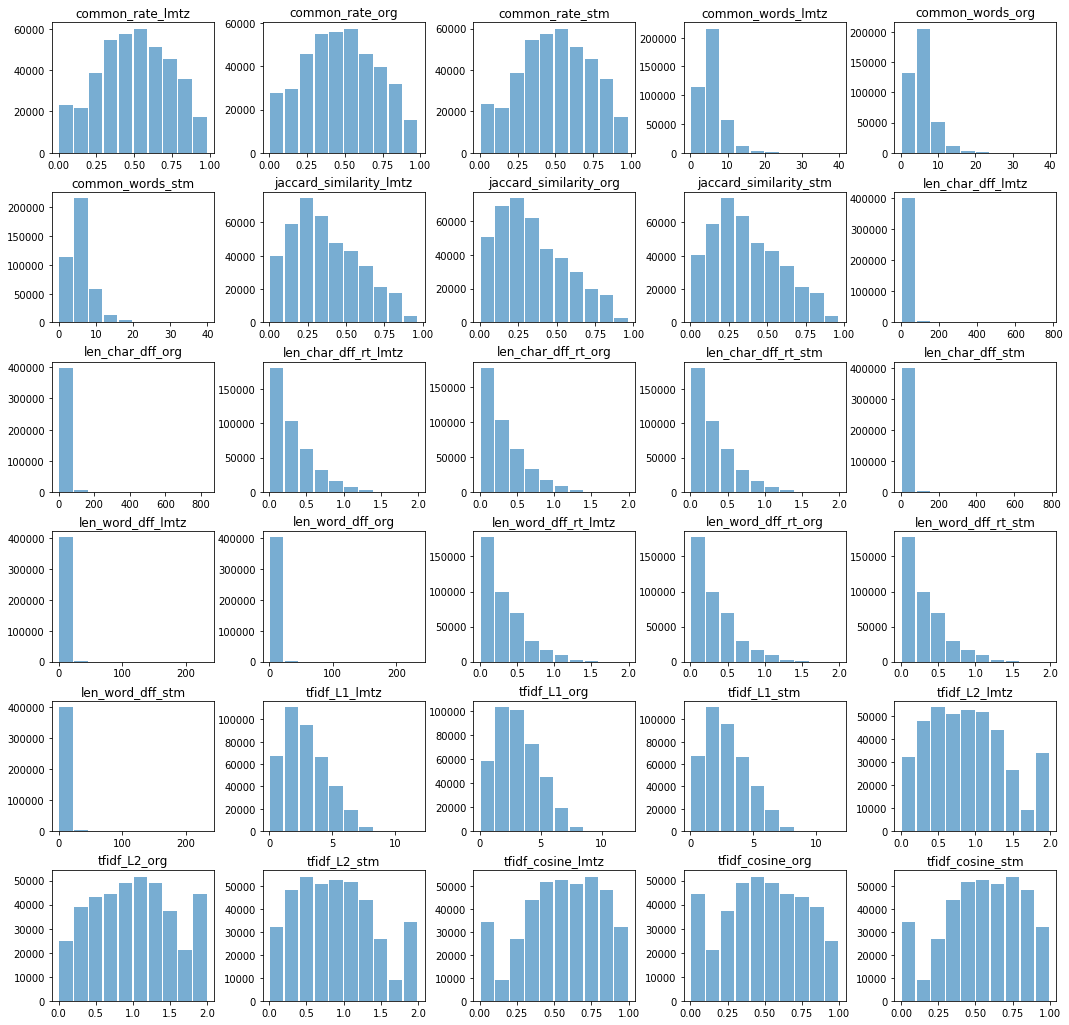

In [10]:
import matplotlib
from IPython.display import display # 允许为DataFrame使用display()
%matplotlib inline
train.hist(rwidth=0.9, grid=False, figsize=(18, 18), alpha=0.6)

In [11]:
train_ft = train
test_ft = test
# 对于倾斜的数据使用Log转换
skewed = ['len_word_dff_org', 'len_word_dff_rt_org', 'len_char_dff_org', 'len_char_dff_rt_org', 
          'common_words_org', 'jaccard_similarity_org', 'tfidf_L1_org', 
         'len_word_dff_stm', 'len_word_dff_rt_stm', 'len_char_dff_stm', 'len_char_dff_rt_stm', 
          'common_words_stm', 'jaccard_similarity_stm', 'tfidf_L1_stm', 
         'len_word_dff_lmtz', 'len_word_dff_rt_lmtz', 'len_char_dff_lmtz', 'len_char_dff_rt_lmtz', 
          'common_words_lmtz', 'jaccard_similarity_lmtz', 'tfidf_L1_lmtz']
train_ft[skewed] = train[skewed].progress_apply(lambda x: np.log(x + 1))
test_ft[skewed] = test[skewed].progress_apply(lambda x: np.log(x + 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f736edc1cf8>,
      dtype=object)

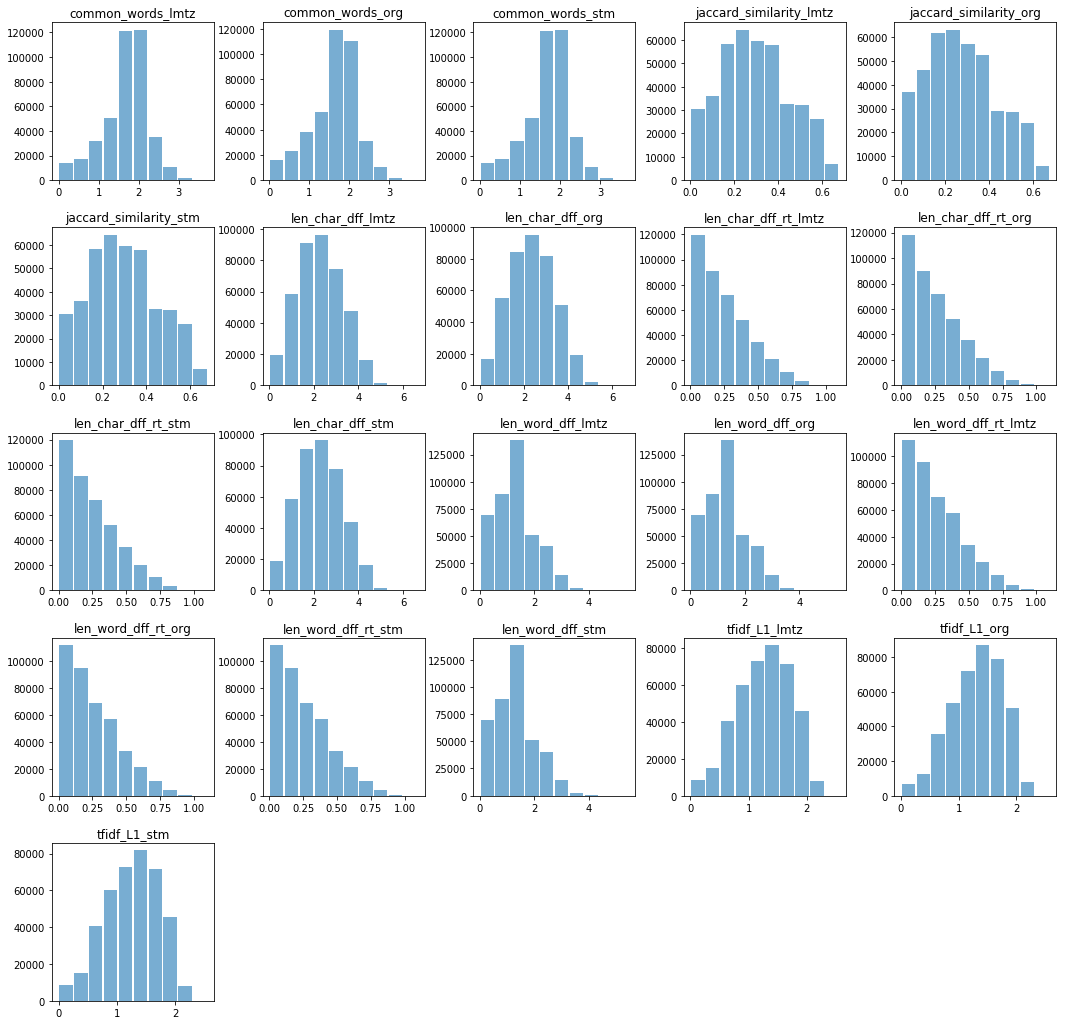

In [13]:
train_ft[skewed].hist(rwidth=0.9, grid=False, figsize=(18, 18), alpha=0.6)

In [0]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = train_ft.columns
train_ft[numerical] = scaler.fit_transform(train_ft[numerical])
test_ft[numerical] = scaler.fit_transform(test_ft[numerical])

# 经过缩放的样例记录
train_ft.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz
0,0.201226,0.130256,0.308934,0.122718,0.669142,0.931944,0.905771,0.119719,0.021487,0.978513,0.201226,0.130256,0.311725,0.125131,0.669142,0.931944,0.905771,0.131732,0.025159,0.974841,0.201226,0.130256,0.312142,0.125131,0.669142,0.931944,0.905771,0.131727,0.025159,0.974841
1,0.328186,0.306270,0.519462,0.417413,0.559957,0.569333,0.485316,0.472151,0.249970,0.750030,0.328186,0.306270,0.504784,0.386085,0.559957,0.569333,0.485316,0.473836,0.243034,0.756966,0.328186,0.306270,0.505459,0.386085,0.559957,0.569333,0.485316,0.473805,0.243016,0.756984
2,0.294791,0.261860,0.356246,0.154649,0.433393,0.325333,0.257581,0.646317,0.745126,0.254874,0.294791,0.261860,0.359463,0.172255,0.482489,0.406667,0.329662,0.592396,0.607603,0.392397,0.294791,0.261860,0.359944,0.175588,0.482489,0.406667,0.329662,0.592372,0.607602,0.392398
3,0.201226,0.140314,0.342086,0.174837,0.000000,0.000000,0.000000,0.719233,1.000000,0.000000,0.201226,0.140314,0.359463,0.212645,0.000000,0.000000,0.000000,0.728213,1.000000,0.000000,0.201226,0.140314,0.359944,0.212645,0.000000,0.000000,0.000000,0.728860,1.000000,0.000000
4,0.356421,0.427816,0.510174,0.449347,0.433393,0.387302,0.312178,0.648933,0.721944,0.278056,0.356421,0.427816,0.504784,0.440371,0.433393,0.387302,0.312178,0.654818,0.714218,0.285782,0.356421,0.427816,0.505459,0.440371,0.433393,0.387302,0.312178,0.654791,0.714218,0.285782


In [14]:
download_from_GCS('train.csv')
train_data = pd.read_csv('train.csv')
train_data.head()

train.csv downloaded


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
train_label = train_data['is_duplicate']

In [19]:
print(train_label.value_counts())

0    255027
1    149263
Name: is_duplicate, dtype: int64


In [20]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'train_ft'和'train_label'切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(train_ft, train_label, test_size=0.2, random_state=0,
                                                    stratify = train_label)

X_test = test_ft

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323432 samples.
Validation set has 80858 samples.
Testing set has 2345796 samples.


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from time import time
clf = DecisionTreeClassifier(random_state=0)
start = time()
clf.fit(X_train, y_train)
end = time()
train_time = end - start

start = time()
predictions_val = clf.predict(X_val)
predictions_train = clf.predict(X_train)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train, predictions_train)
log_loss_val = log_loss(y_val, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 15.466032266616821 s
predict time: 0.18372535705566406 s
train set log_loss: 0.047948866088676004
val set log_loss: 11.215901120775214


In [22]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier()
start = time()
clf2.fit(X_train, y_train)
end = time()
train_time = end - start

start = time()
predictions_val = clf2.predict(X_val)
predictions_train = clf2.predict(X_train)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train, predictions_train)
log_loss_val = log_loss(y_val, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))

train time: 18.084019660949707 s
predict time: 1.4964239597320557 s
train set log_loss: 0.5014808130406835
val set log_loss: 10.024529302199245


In [23]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

dtrain = xgb.DMatrix(X_train, label = y_train)
dtrain_p = xgb.DMatrix(X_train)
dval = xgb.DMatrix(X_val)

params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

start = time()
model = xgb.train(params, dtrain, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model.predict(dtrain_p)
predictions_val = model.predict(dval)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train, predictions_train)
log_loss_val = log_loss(y_val, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 31.158703327178955 s
predict time: 0.250138521194458 s
train set log_loss: 0.5221025680217578
val set log_loss: 0.5564301762222122


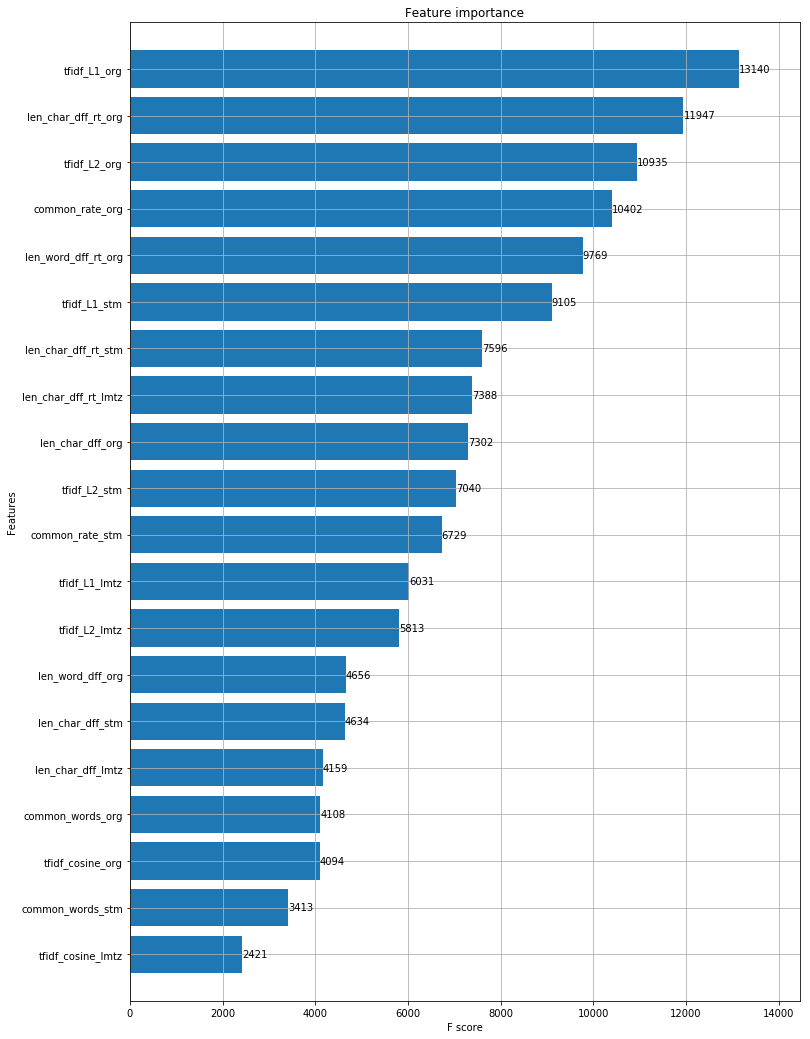

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [27]:
download_from_GCS('encode_ft_train.csv')
download_from_GCS('encode_ft_test.csv')

encode_ft_train.csv downloaded
encode_ft_test.csv downloaded


In [28]:
encode_ft_train = pd.read_csv('encode_ft_train.csv')
encode_ft_test = pd.read_csv('encode_ft_test.csv')
encode_ft_train.head()

,encode_L1,encode_L2,encode_cos
0,2.133778,0.269064,0.963802
1,3.548461,0.724755,0.737365
2,2.765091,0.456800,0.895667
3,4.717258,1.238057,0.233607
4,4.118772,0.973915,0.525745


In [30]:
train_ft2 = pd.concat([train_ft, encode_ft_train], axis=1)
train_ft2.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745


In [32]:
encode_ft_test = encode_ft_test.iloc[:, 1:encode_ft_test.shape[1]]
test_ft2 = pd.concat([test_ft, encode_ft_test], axis=1)
test_ft2.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos
0,1.386294,0.215111,2.197225,0.148420,1.386294,0.250000,0.133531,1.719823,1.435170,0.282415,1.386294,0.215111,2.302585,0.173511,1.386294,0.250000,0.133531,1.734239,1.475020,0.262490,1.386294,0.215111,2.197225,0.157186,1.386294,0.250000,0.133531,1.689093,1.452190,0.273905,3.637099,0.784084,0.692606
1,2.079442,0.510826,2.772589,0.296266,1.791759,0.454545,0.257829,1.312116,0.789032,0.605484,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.865691,0.488314,0.880775
2,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.260385,0.601267,0.699367,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.259183,0.597581,0.701209,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.284690,0.623996,0.688002,3.039441,0.545916,0.850988
3,0.693147,0.251314,2.302585,0.396415,0.000000,0.000000,0.000000,1.449417,2.000000,0.000000,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,3.665707,0.754944,0.715030
4,1.098612,0.336472,1.098612,0.076961,1.386294,0.545455,0.318454,0.676052,0.305440,0.847280,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,3.948551,0.896182,0.598429


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7324d16ef0>,
      dtype=object)

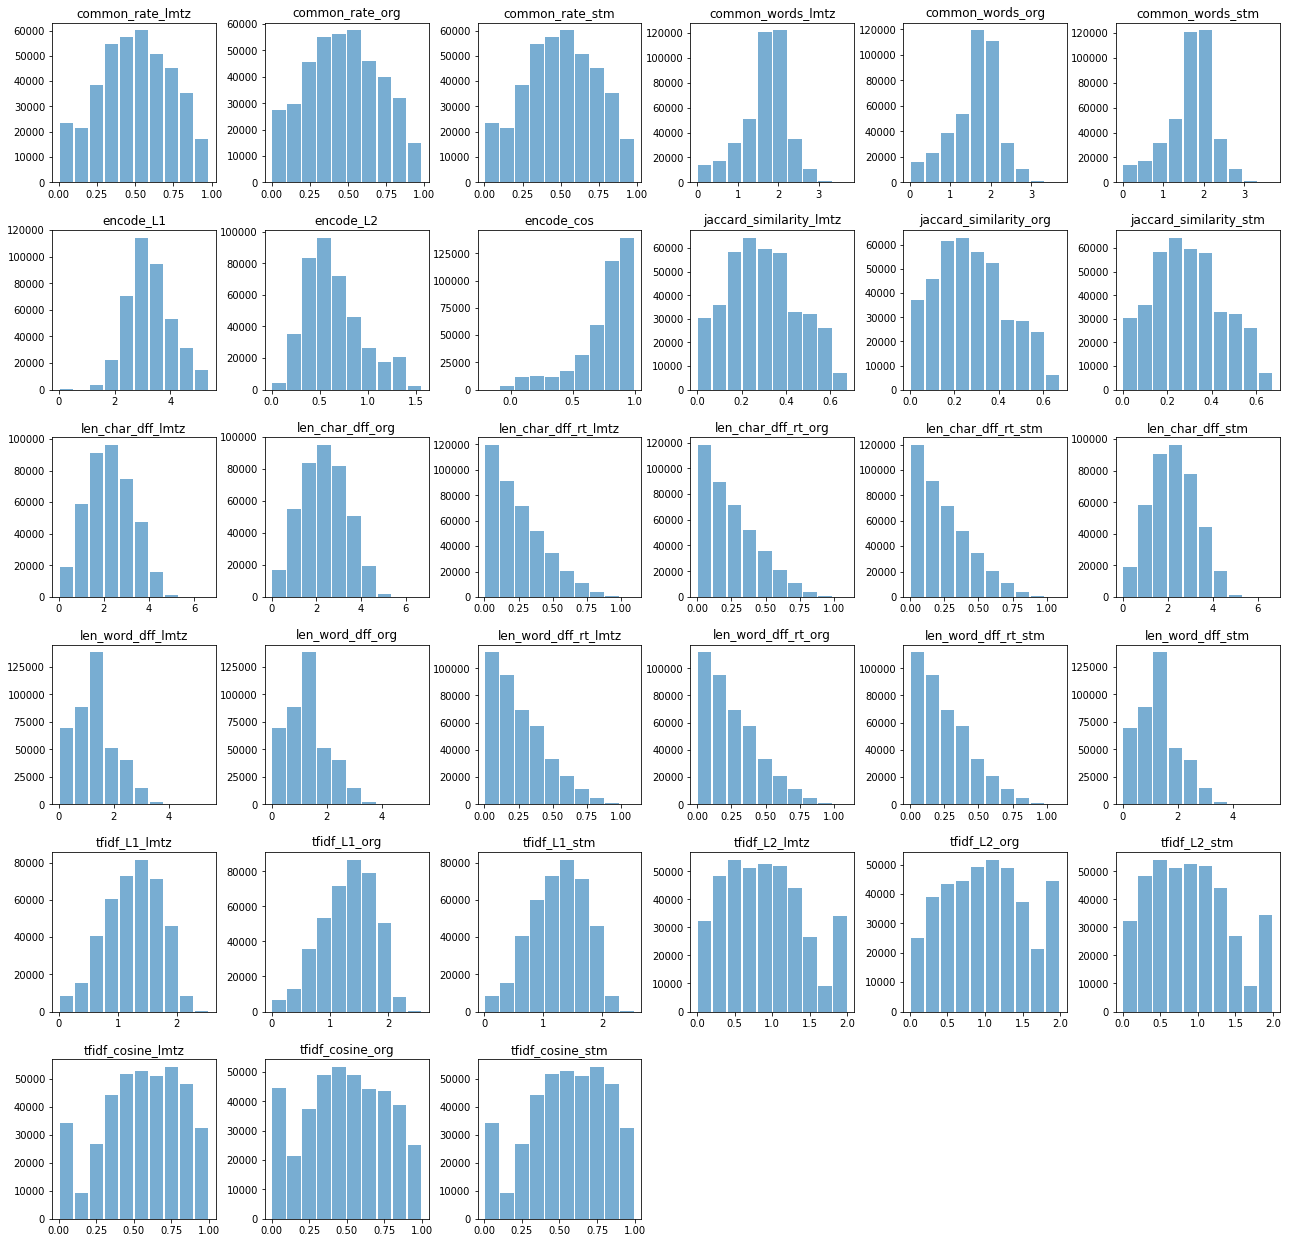

In [35]:
train_ft2.hist(rwidth=0.9, grid=False, figsize=(22, 22), alpha=0.6)

In [36]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'train_ft'和'train_label'切分为训练集和验证集
X_train2, X_val2, y_train2, y_val2 = train_test_split(train_ft2, train_label, test_size=0.2, random_state=0,
                                                    stratify = train_label)

X_test2 = test_ft2

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323432 samples.
Validation set has 80858 samples.
Testing set has 2345796 samples.


In [37]:

clf2 = DecisionTreeClassifier(random_state=0)
start = time()
clf2.fit(X_train2, y_train2)
end = time()
train_time = end - start

start = time()
predictions_val = clf2.predict(X_val2)
predictions_train = clf2.predict(X_train2)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train2, predictions_train)
log_loss_val = log_loss(y_val2, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 16.7550311088562 s
predict time: 0.17735052108764648 s
train set log_loss: 0.0058734543471974255
val set log_loss: 10.073678237559808


In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
start = time()
rf.fit(X_train2, y_train2)
end = time()
train_time = end - start

start = time()
predictions_val = rf.predict(X_val2)
predictions_train = rf.predict(X_train2)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train2, predictions_train)
log_loss_val = log_loss(y_val2, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))

train time: 18.494015216827393 s
predict time: 1.516099452972412 s
train set log_loss: 0.41220511192051673
val set log_loss: 8.535891292283667


In [39]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

dtrain2 = xgb.DMatrix(X_train2, label = y_train2)
dtrain2_p = xgb.DMatrix(X_train2)
dval2 = xgb.DMatrix(X_val2)

params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

start = time()
model2 = xgb.train(params, dtrain2, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model2.predict(dtrain2_p)
predictions_val = model2.predict(dval2)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train2, predictions_train)
log_loss_val = log_loss(y_val2, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.19288873672485 s
predict time: 0.3284938335418701 s
train set log_loss: 0.45540924192514926
val set log_loss: 0.49056796546472436


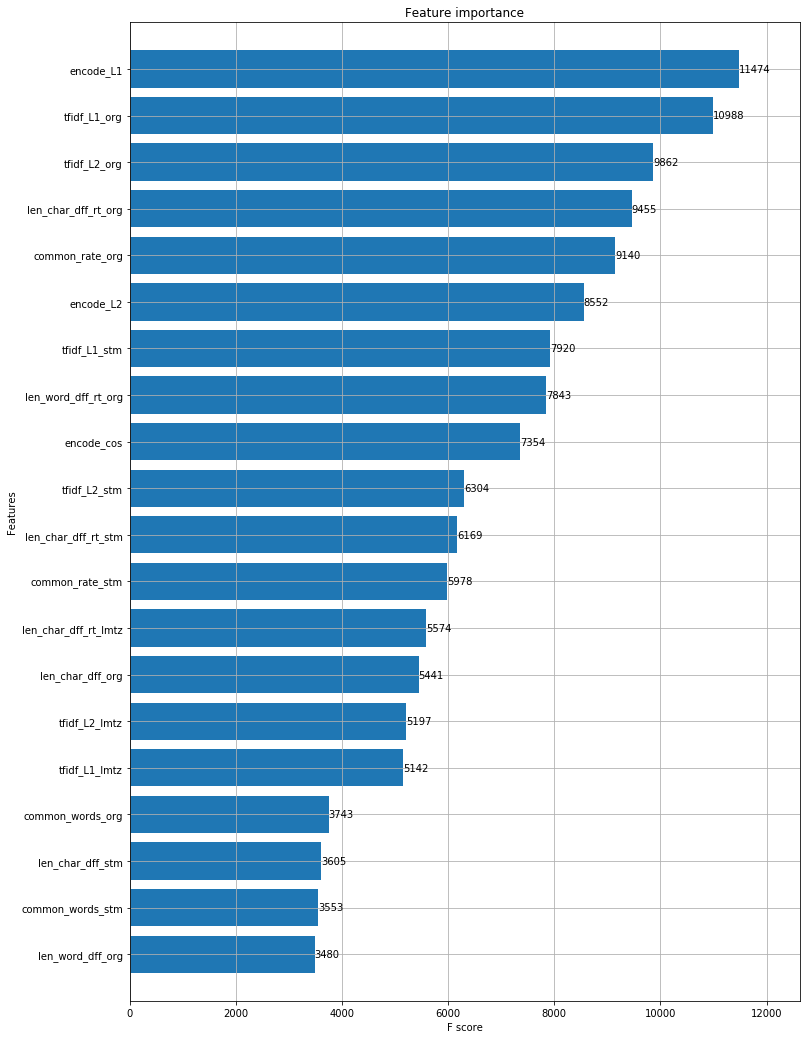

In [41]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model2, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [47]:
encode_ft_train2 = train_ft2.loc[:, ['encode_L1', 'encode_L2', 'encode_cos']]
encode_ft_test2 = test_ft2.loc[:, ['encode_L1', 'encode_L2', 'encode_cos']]
# 对于倾斜的数据使用Log转换
skewed = ['encode_cos']
encode_ft_train2[skewed] = encode_ft_train2[skewed].progress_apply(lambda x: np.log(x + 1))
encode_ft_test2[skewed] = encode_ft_test2[skewed].progress_apply(lambda x: np.log(x + 1))
encode_cos_log_train = encode_ft_train2[skewed].rename(columns=lambda x: x + '_log')
encode_cos_log_test = encode_ft_test2[skewed].rename(columns=lambda x: x + '_log')
encode_cos_log_train.head()

,encode_cos_log
0,0.674883
1,0.552370
2,0.639571
3,0.209942
4,0.422483


In [48]:
train_ft3 = pd.concat([train_ft2, encode_cos_log_train], axis=1)
train_ft3.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802,0.674883
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365,0.552370
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667,0.639571
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745,0.422483


In [49]:
test_ft3 = pd.concat([test_ft2, encode_cos_log_test], axis=1)
test_ft3.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log
0,1.386294,0.215111,2.197225,0.148420,1.386294,0.250000,0.133531,1.719823,1.435170,0.282415,1.386294,0.215111,2.302585,0.173511,1.386294,0.250000,0.133531,1.734239,1.475020,0.262490,1.386294,0.215111,2.197225,0.157186,1.386294,0.250000,0.133531,1.689093,1.452190,0.273905,3.637099,0.784084,0.692606,0.526269
1,2.079442,0.510826,2.772589,0.296266,1.791759,0.454545,0.257829,1.312116,0.789032,0.605484,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.865691,0.488314,0.880775,0.631684
2,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.260385,0.601267,0.699367,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.259183,0.597581,0.701209,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.284690,0.623996,0.688002,3.039441,0.545916,0.850988,0.615720
3,0.693147,0.251314,2.302585,0.396415,0.000000,0.000000,0.000000,1.449417,2.000000,0.000000,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,3.665707,0.754944,0.715030,0.539430
4,1.098612,0.336472,1.098612,0.076961,1.386294,0.545455,0.318454,0.676052,0.305440,0.847280,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,3.948551,0.896182,0.598429,0.469021


In [50]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'train_ft'和'train_label'切分为训练集和验证集
X_train3, X_val3, y_train3, y_val3 = train_test_split(train_ft3, train_label, test_size=0.2, random_state=0,
                                                    stratify = train_label)

X_test3 = test_ft3

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323432 samples.
Validation set has 80858 samples.
Testing set has 2345796 samples.


In [51]:

dt3 = DecisionTreeClassifier(random_state=0)
start = time()
dt3.fit(X_train3, y_train3)
end = time()
train_time = end - start

start = time()
predictions_val = dt3.predict(X_val3)
predictions_train = dt3.predict(X_train3)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train3, predictions_train)
log_loss_val = log_loss(y_val3, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 17.701503038406372 s
predict time: 0.18323588371276855 s
train set log_loss: 0.0058734543471974255
val set log_loss: 10.067697871230289


In [52]:

rf3 = RandomForestClassifier()
start = time()
rf3.fit(X_train3, y_train3)
end = time()
train_time = end - start

start = time()
predictions_val = rf3.predict(X_val3)
predictions_train = rf3.predict(X_train3)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train3, predictions_train)
log_loss_val = log_loss(y_val3, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 18.671452283859253 s
predict time: 1.4328324794769287 s
train set log_loss: 0.42138895385056274
val set log_loss: 8.596547947321557


In [53]:
#添加 feature encode_cos_log
dtrain3 = xgb.DMatrix(X_train3, label = y_train3)
dtrain3_p = xgb.DMatrix(X_train3)
dval3 = xgb.DMatrix(X_val3)


start = time()
model3 = xgb.train(params, dtrain3, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model3.predict(dtrain3_p)
predictions_val = model3.predict(dval3)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train3, predictions_train)
log_loss_val = log_loss(y_val3, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.80988264083862 s
predict time: 0.32914066314697266 s
train set log_loss: 0.45542891204586694
val set log_loss: 0.49051744886523946


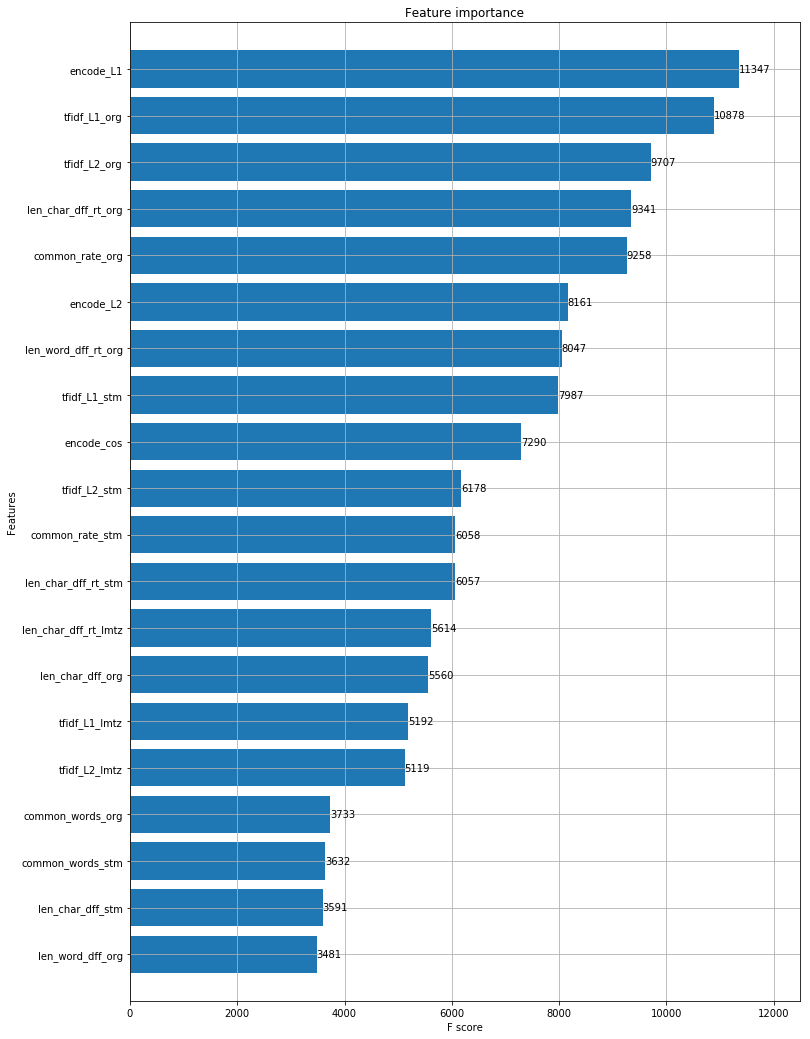

In [54]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model3, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [59]:
# 去除未log的encode_cos
X_train4 = X_train3.drop('encode_cos',axis=1)
X_val4 = X_val3.drop('encode_cos',axis=1)
X_test4 = X_test3.drop('encode_cos',axis=1)

y_train4 = y_train3
y_val4 = y_val3

#添加 feature encode_cos_log
dtrain4 = xgb.DMatrix(X_train4, label = y_train4)
dtrain4_p = xgb.DMatrix(X_train4)
dval4 = xgb.DMatrix(X_val4)


start = time()
model4 = xgb.train(params, dtrain4, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model4.predict(dtrain4_p)
predictions_val = model4.predict(dval4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.23064208030701 s
predict time: 0.32830333709716797 s
train set log_loss: 0.45547640247924576
val set log_loss: 0.49058923020274586


In [60]:
download_from_GCS('x_train_tk_stwd_ft.csv')
download_from_GCS('x_test_tk_stwd_ft.csv')

x_train_tk_stwd_ft.csv downloaded
x_test_tk_stwd_ft.csv downloaded


In [61]:
train_ft_stwd = pd.read_csv('x_train_tk_stwd_ft.csv')
test_ft_stwd = pd.read_csv('x_test_tk_stwd_ft.csv')
train_ft_stwd.head()

,id,question1,question2,common_words,common_rate,jaccard_similarity,tfidf_L1,tfidf_L2,tfidf_cosine
0,0,step step guide invest share market india,step step guide invest share market,5.0,0.833333,0.714286,0.228000,0.036422,0.981789
1,1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,4.0,0.500000,0.333333,2.010116,0.475765,0.762118
2,2,increase speed internet connection using vpn,internet speed increased hacking dns,2.0,0.333333,0.200000,3.179522,1.447160,0.276420
3,3,mentally lonely solve,find remainder math 23 24 math divided 24 23,0.0,0.000000,0.000000,4.029625,2.000000,0.000000
4,4,one dissolve water quickly sugar salt methane ...,fish would survive salt water,2.0,0.250000,0.142857,4.203730,1.504143,0.247928


In [62]:
test_ft_stwd.head()

,test_id,question1,question2,common_words,common_rate,jaccard_similarity,tfidf_L1,tfidf_L2,tfidf_cosine
0,0,surface pro 4 compare ipad pro,microsoft choose core m3 core i3 home surface ...,3.0,0.400000,0.250000,3.426962,1.332189,0.333906
1,1,hair transplant age 24 much would cost,much cost hair transplant require,4.0,0.615385,0.444444,1.718887,0.661058,0.669471
2,2,best way send money china america,send money china,3.0,0.600000,0.428571,1.344621,0.390172,0.804914
3,3,food emulsifiers,foods fibre,0.0,0.000000,0.000000,2.732294,2.000000,0.000000
4,4,aberystwyth start reading,start reading,2.0,0.666667,0.500000,0.000000,0.000000,1.000000


In [63]:
train_ft_stwd = train_ft_stwd.rename(columns=lambda x: x + '_stwd')
test_ft_stwd = test_ft_stwd.rename(columns=lambda x: x + '_stwd')
train_ft_stwd.head()

,id_stwd,question1_stwd,question2_stwd,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd,tfidf_cosine_stwd
0,0,step step guide invest share market india,step step guide invest share market,5.0,0.833333,0.714286,0.228000,0.036422,0.981789
1,1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,4.0,0.500000,0.333333,2.010116,0.475765,0.762118
2,2,increase speed internet connection using vpn,internet speed increased hacking dns,2.0,0.333333,0.200000,3.179522,1.447160,0.276420
3,3,mentally lonely solve,find remainder math 23 24 math divided 24 23,0.0,0.000000,0.000000,4.029625,2.000000,0.000000
4,4,one dissolve water quickly sugar salt methane ...,fish would survive salt water,2.0,0.250000,0.142857,4.203730,1.504143,0.247928


In [65]:
train_ft4 = pd.concat([train_ft3, train_ft_stwd.iloc[:, 3:8]], axis=1)
train_ft4.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802,0.674883,5.0,0.833333,0.714286,0.228000,0.036422
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365,0.552370,4.0,0.500000,0.333333,2.010116,0.475765
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667,0.639571,2.0,0.333333,0.200000,3.179522,1.447160
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942,0.0,0.000000,0.000000,4.029625,2.000000
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745,0.422483,2.0,0.250000,0.142857,4.203730,1.504143


In [66]:
test_ft4 = pd.concat([test_ft3, test_ft_stwd.iloc[:, 3:8]], axis=1)
test_ft4.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd
0,1.386294,0.215111,2.197225,0.148420,1.386294,0.250000,0.133531,1.719823,1.435170,0.282415,1.386294,0.215111,2.302585,0.173511,1.386294,0.250000,0.133531,1.734239,1.475020,0.262490,1.386294,0.215111,2.197225,0.157186,1.386294,0.250000,0.133531,1.689093,1.452190,0.273905,3.637099,0.784084,0.692606,0.526269,3.0,0.400000,0.250000,3.426962,1.332189
1,2.079442,0.510826,2.772589,0.296266,1.791759,0.454545,0.257829,1.312116,0.789032,0.605484,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.865691,0.488314,0.880775,0.631684,4.0,0.615385,0.444444,1.718887,0.661058
2,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.260385,0.601267,0.699367,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.259183,0.597581,0.701209,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.284690,0.623996,0.688002,3.039441,0.545916,0.850988,0.615720,3.0,0.600000,0.428571,1.344621,0.390172
3,0.693147,0.251314,2.302585,0.396415,0.000000,0.000000,0.000000,1.449417,2.000000,0.000000,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,3.665707,0.754944,0.715030,0.539430,0.0,0.000000,0.000000,2.732294,2.000000
4,1.098612,0.336472,1.098612,0.076961,1.386294,0.545455,0.318454,0.676052,0.305440,0.847280,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,3.948551,0.896182,0.598429,0.469021,2.0,0.666667,0.500000,0.000000,0.000000


In [67]:
skewed = [ 'common_words_stwd', 'jaccard_similarity_stwd', 'tfidf_L1_stwd']
train_ft4[skewed] = train_ft4[skewed].progress_apply(lambda x: np.log(x + 1))
test_ft4[skewed] = test_ft4[skewed].progress_apply(lambda x: np.log(x + 1))

In [68]:
train_ft4.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802,0.674883,1.791759,0.833333,0.538997,0.205387,0.036422
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365,0.552370,1.609438,0.500000,0.287682,1.101979,0.475765
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667,0.639571,1.098612,0.333333,0.182322,1.430197,1.447160
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942,0.000000,0.000000,0.000000,1.615345,2.000000
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745,0.422483,1.098612,0.250000,0.133531,1.649376,1.504143


In [69]:

# 将'train_ft'和'train_label'切分为训练集和验证集
X_train4, X_val4, y_train4, y_val4 = train_test_split(train_ft4, train_label, test_size=0.2, random_state=0,
                                                    stratify = train_label)

X_test4 = test_ft4

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323432 samples.
Validation set has 80858 samples.
Testing set has 2345796 samples.


In [70]:

dt4 = DecisionTreeClassifier(random_state=0)
start = time()
dt4.fit(X_train4, y_train4)
end = time()
train_time = end - start

start = time()
predictions_val = dt4.predict(X_val4)
predictions_train = dt4.predict(X_train4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 19.813995122909546 s
predict time: 0.18416452407836914 s
train set log_loss: 0.005553076873193978
val set log_loss: 9.52905081133901


In [71]:

rf4 = RandomForestClassifier()
start = time()
rf4.fit(X_train4, y_train4)
end = time()
train_time = end - start

start = time()
predictions_val = rf4.predict(X_val4)
predictions_train = rf4.predict(X_train4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 21.75764513015747 s
predict time: 1.4590301513671875 s
train set log_loss: 0.37472234427055556
val set log_loss: 8.218514088132489


In [72]:
#添加 removing stop words features
dtrain4 = xgb.DMatrix(X_train4, label = y_train4)
dtrain4_p = xgb.DMatrix(X_train4)
dval4 = xgb.DMatrix(X_val4)


start = time()
model4 = xgb.train(params, dtrain4, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model4.predict(dtrain4_p)
predictions_val = model4.predict(dval4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 38.56170606613159 s
predict time: 0.340747594833374 s
train set log_loss: 0.4307283409043428
val set log_loss: 0.4679220610692612


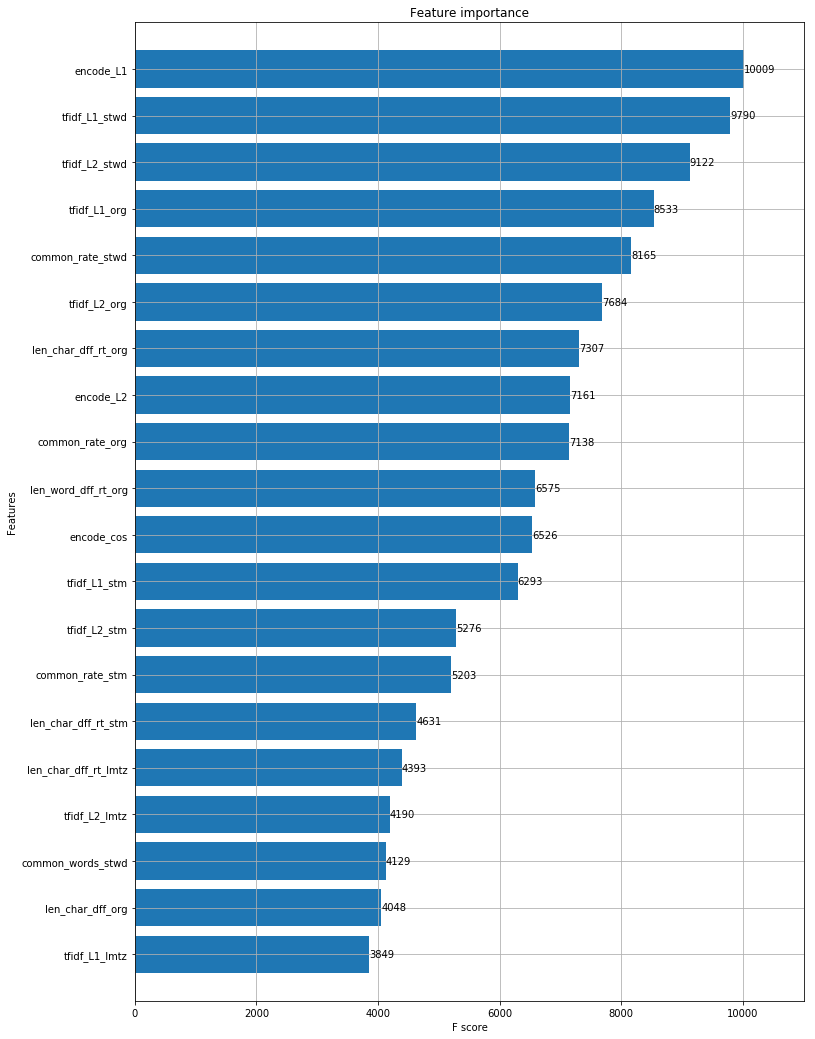

In [73]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model4, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [74]:
# 去除未 stm lmtz

drop_features = ['len_word_dff_stm', 'len_word_dff_rt_stm', 'len_char_dff_stm', 'len_char_dff_rt_stm', 
          'common_words_stm', 'common_rate_stm','jaccard_similarity_stm', 'tfidf_L1_stm', 'tfidf_L2_stm','tfidf_cosine_stm',
         'len_word_dff_lmtz', 'len_word_dff_rt_lmtz', 'len_char_dff_lmtz', 'len_char_dff_rt_lmtz', 
          'common_words_lmtz', 'common_rate_lmtz','jaccard_similarity_lmtz', 'tfidf_L1_lmtz', 'tfidf_L2_lmtz','tfidf_cosine_lmtz']

X_train5 = X_train4.drop(drop_features,axis=1)
X_val5 = X_val4.drop(drop_features,axis=1)
X_test5 = X_test4.drop(drop_features,axis=1)

y_train5 = y_train4
y_val5 = y_val4

#添加 feature encode_cos_log
dtrain5 = xgb.DMatrix(X_train5, label = y_train5)
dtrain5_p = xgb.DMatrix(X_train5)
dval5 = xgb.DMatrix(X_val5)


start = time()
model5 = xgb.train(params, dtrain5, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model5.predict(dtrain5_p)
predictions_val = model5.predict(dval5)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train5, predictions_train)
log_loss_val = log_loss(y_val5, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.259767293930054 s
predict time: 0.19637703895568848 s
train set log_loss: 0.4446031518971855
val set log_loss: 0.4776364562664587


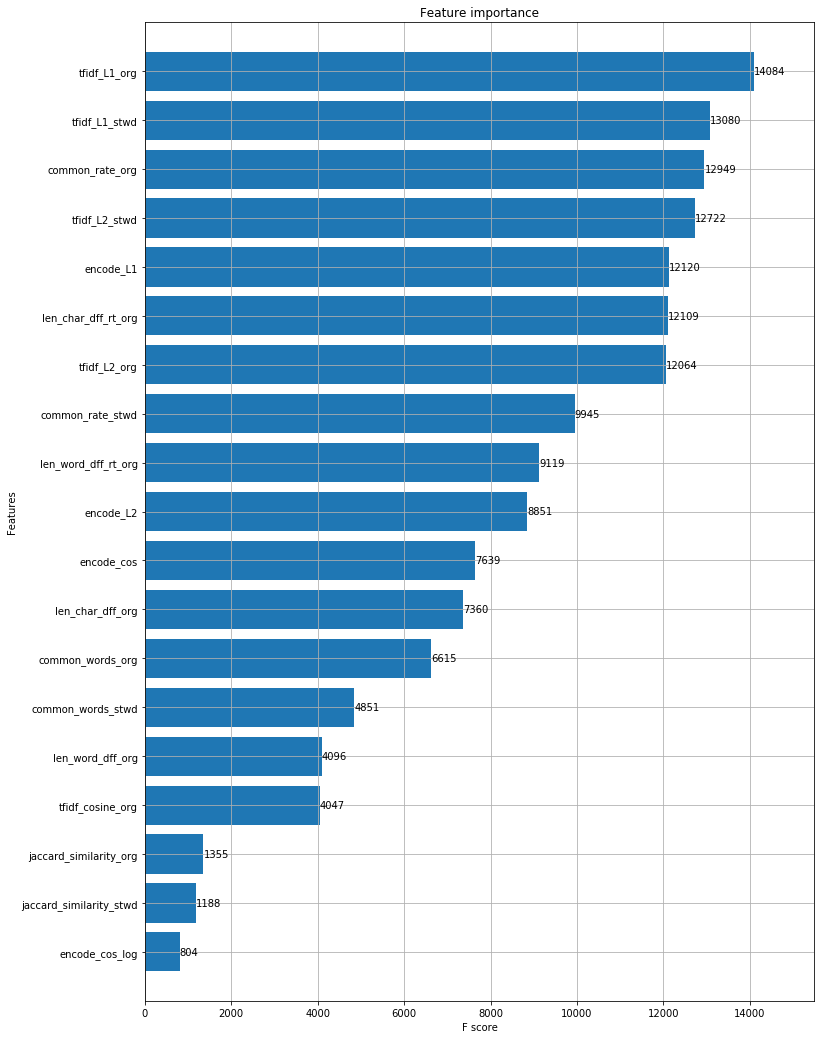

In [75]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model5, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [76]:
train_ft4.to_csv('train_ft_all.csv', index=False)
test_ft4.to_csv('test_ft_all.csv', index=False)
upload_to_GCS('train_ft_all.csv')
upload_to_GCS('test_ft_all.csv')

train_ft_all.csv uploaded
test_ft_all.csv uploaded


In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

dtrain = xgb.DMatrix(X_train, label = y_train)
dtrain_p = xgb.DMatrix(X_train)
dval = xgb.DMatrix(X_val)

params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

start = time()
model = xgb.train(params, dtrain, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model.predict(dtrain_p)
predictions_val = model.predict(dval)
end = time()
predict_time = end - start


In [0]:
log_loss_train = log_loss(y_train, predictions_train)
log_loss_val = log_loss(y_val, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))

train time: 312.60965275764465 s
predict time: 1.0736591815948486 s
train set log_loss: 0.5221338658375846
val set log_loss: 0.5563620702769658
